<a href="https://colab.research.google.com/github/LindeHoek/TM10007_ML/blob/main/TM10007_Group7_Classifier_T_stage_H%26N_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Machine Learning - Classifier for T-stage H&N cancer

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/LindeHoek/TM10007_ML.git

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Importing functions

In [ ]:
# Data import
from hn.load_data import load_data
from sklearn.model_selection import StratifiedKFold

# Preprocessing
import pandas as pd
import numpy as np
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV

# Classifiers
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Results
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.model_selection import learning_curve


## Function for plotting learning curves

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

## Import data

In [ ]:
# Data loading
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)}')
print(f'There are {data.isnull().sum().sum()} empty cells')

The number of samples: 113
The number of features: 160
There are 0 empty cells


## Checking data distribution

In [ ]:
# Checking for normal distribution of data
from scipy import stats

distributions = []
for x in data.columns:
  if x == 'label':
    continue
  else:
    data_array = data[x].to_numpy()
    shapiro_test = stats.shapiro(data_array)
    k, p = shapiro_test
    distributions.append(p)

print(f'{len([element for element in distributions if element > 0.05])} of the {len(data.columns)-1} features are normally distributed.')

13 of the 159 features are normally distributed.


## Cross validation loop

loop 1
Num Features: 47
Hyperparameters Linear: {'C': 3, 'gamma': 0.1}
Hyperparameters KNN: {'n_neighbors': 27}
Hyperparameters RBF: {'C': 3, 'gamma': 0.2}
loop 2
Num Features: 13
Hyperparameters Linear: {'C': 1, 'gamma': 0.1}
Hyperparameters KNN: {'n_neighbors': 5}
Hyperparameters RBF: {'C': 5, 'gamma': 0.1}
loop 3
Num Features: 11
Hyperparameters Linear: {'C': 3, 'gamma': 0.1}
Hyperparameters KNN: {'n_neighbors': 30}
Hyperparameters RBF: {'C': 15, 'gamma': 1.0}
loop 4
Num Features: 13
Hyperparameters Linear: {'C': 11, 'gamma': 0.1}
Hyperparameters KNN: {'n_neighbors': 22}
Hyperparameters RBF: {'C': 5, 'gamma': 1.6}
loop 5
Num Features: 12
Hyperparameters Linear: {'C': 2, 'gamma': 0.1}
Hyperparameters KNN: {'n_neighbors': 12}
Hyperparameters RBF: {'C': 4, 'gamma': 2.2}
loop 6
Num Features: 14
Hyperparameters Linear: {'C': 12, 'gamma': 0.1}
Hyperparameters KNN: {'n_neighbors': 13}
Hyperparameters RBF: {'C': 5, 'gamma': 0.2}
loop 7
Num Features: 44
Hyperparameters Linear: {'C': 1, 'gamm

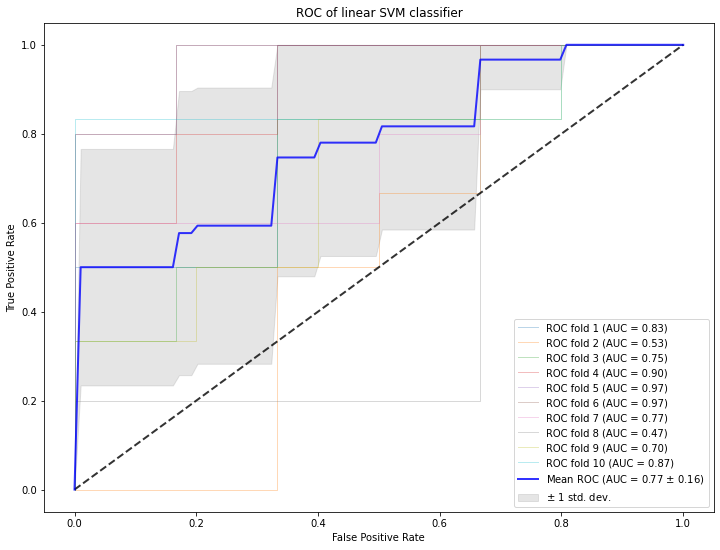

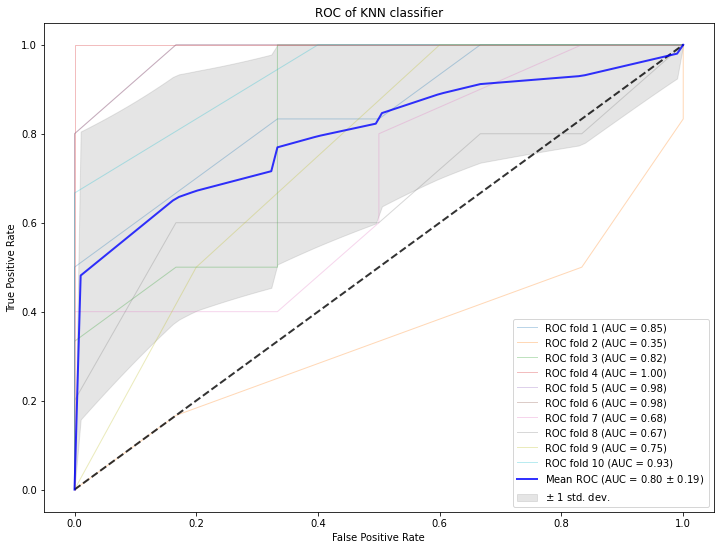

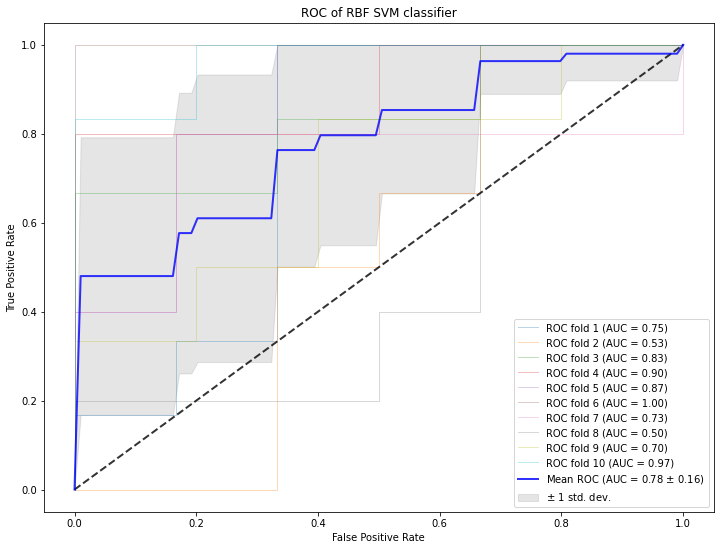

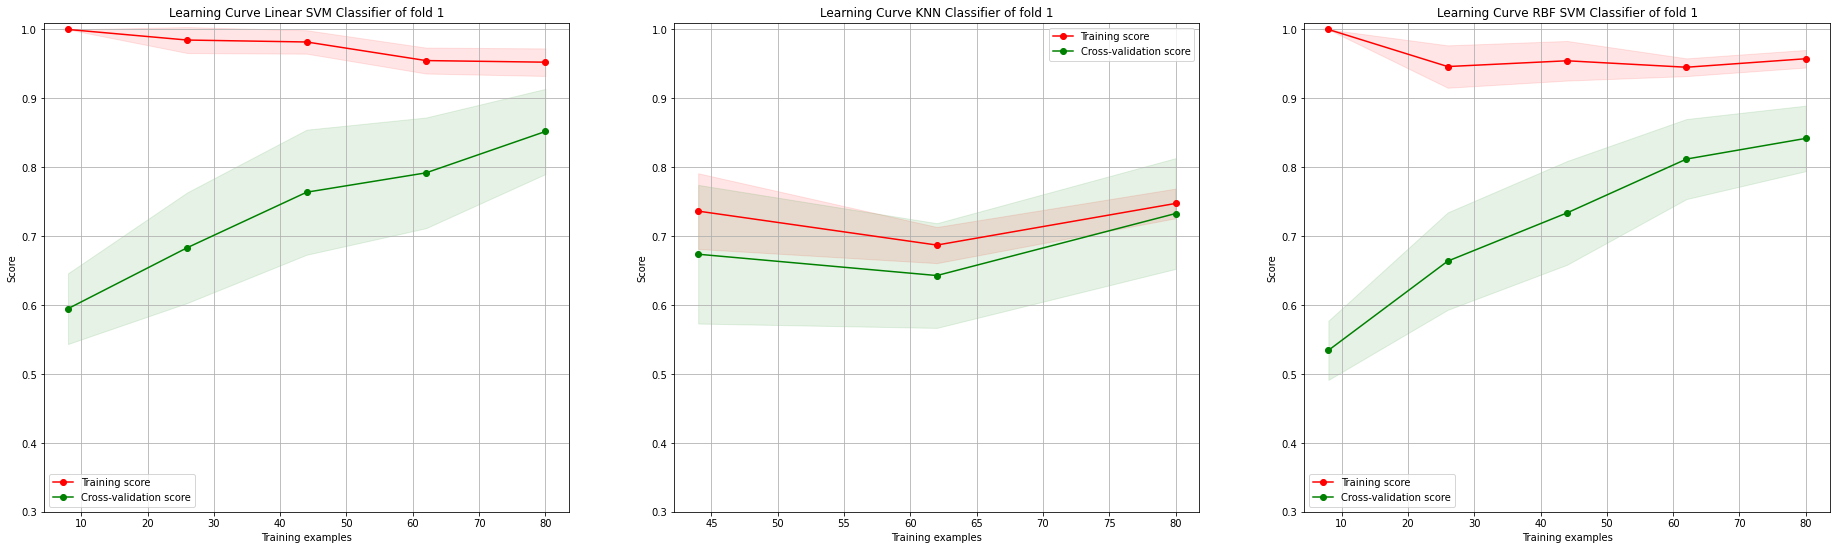

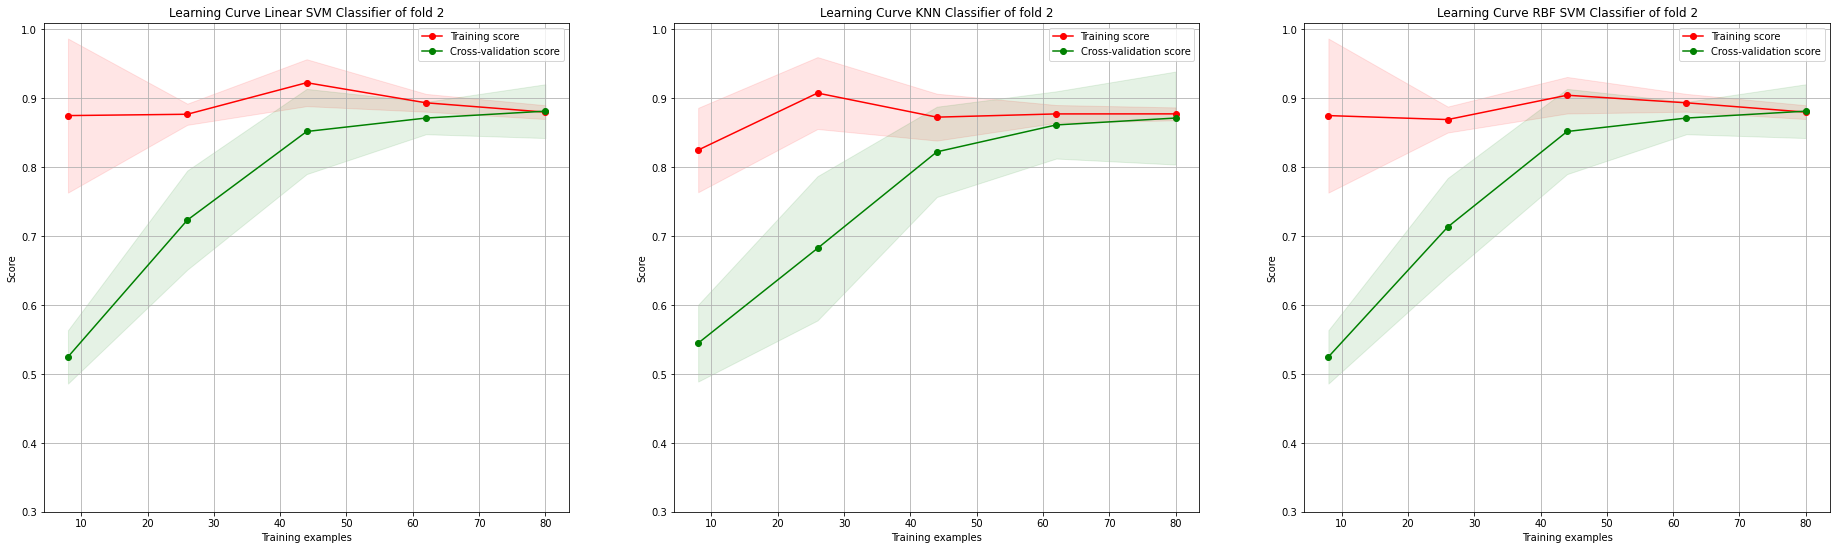

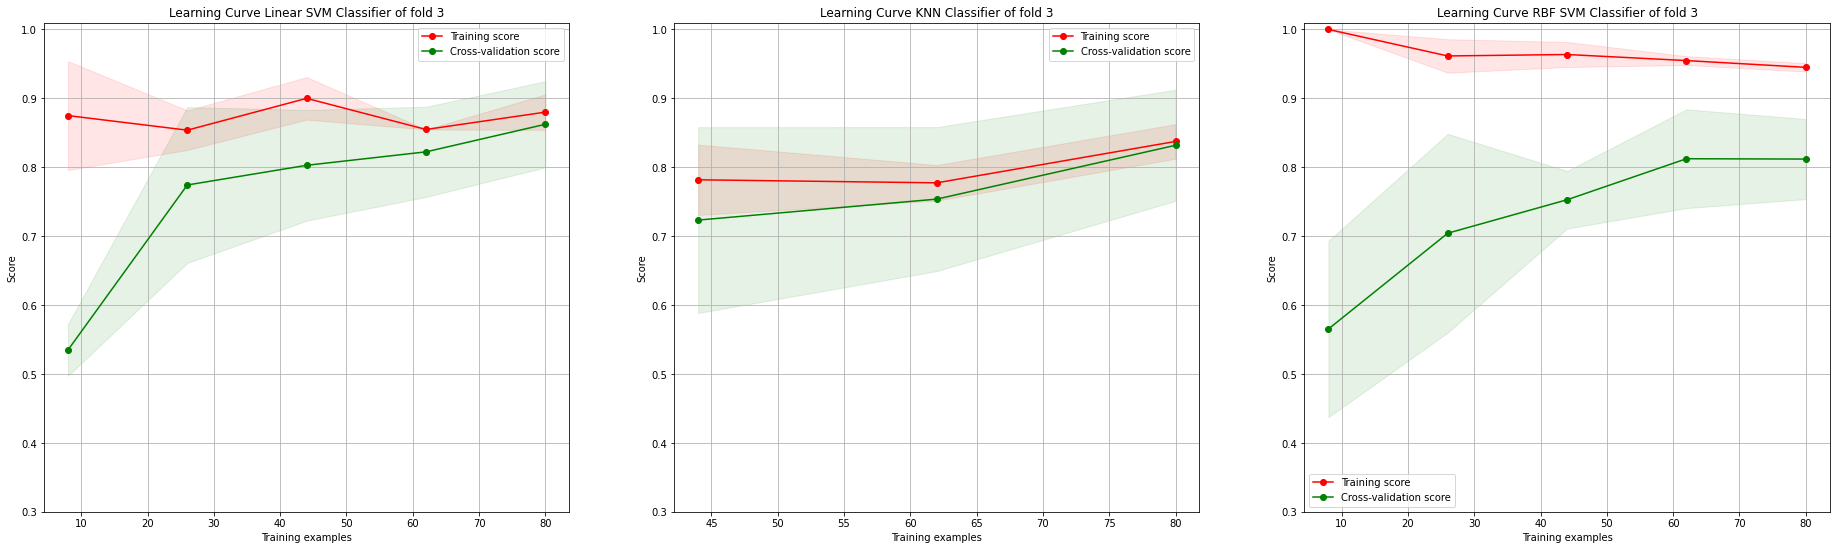

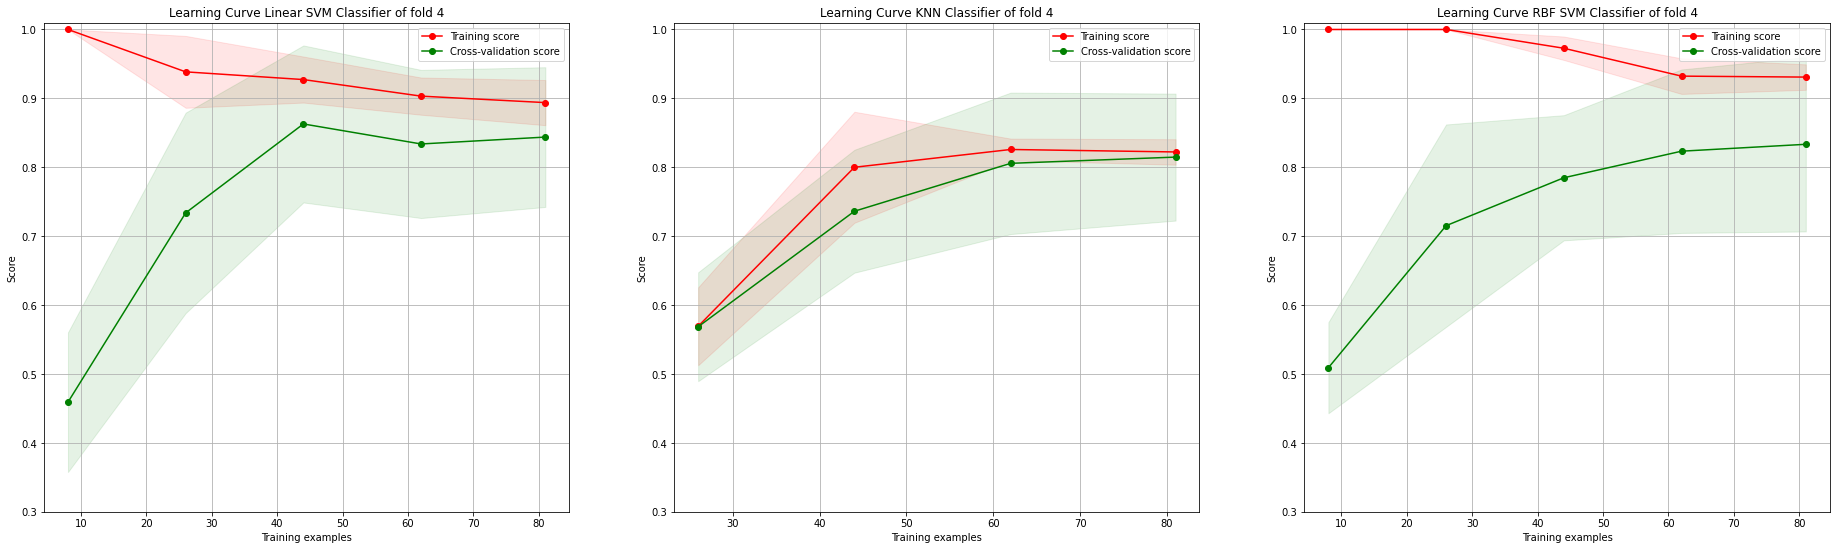

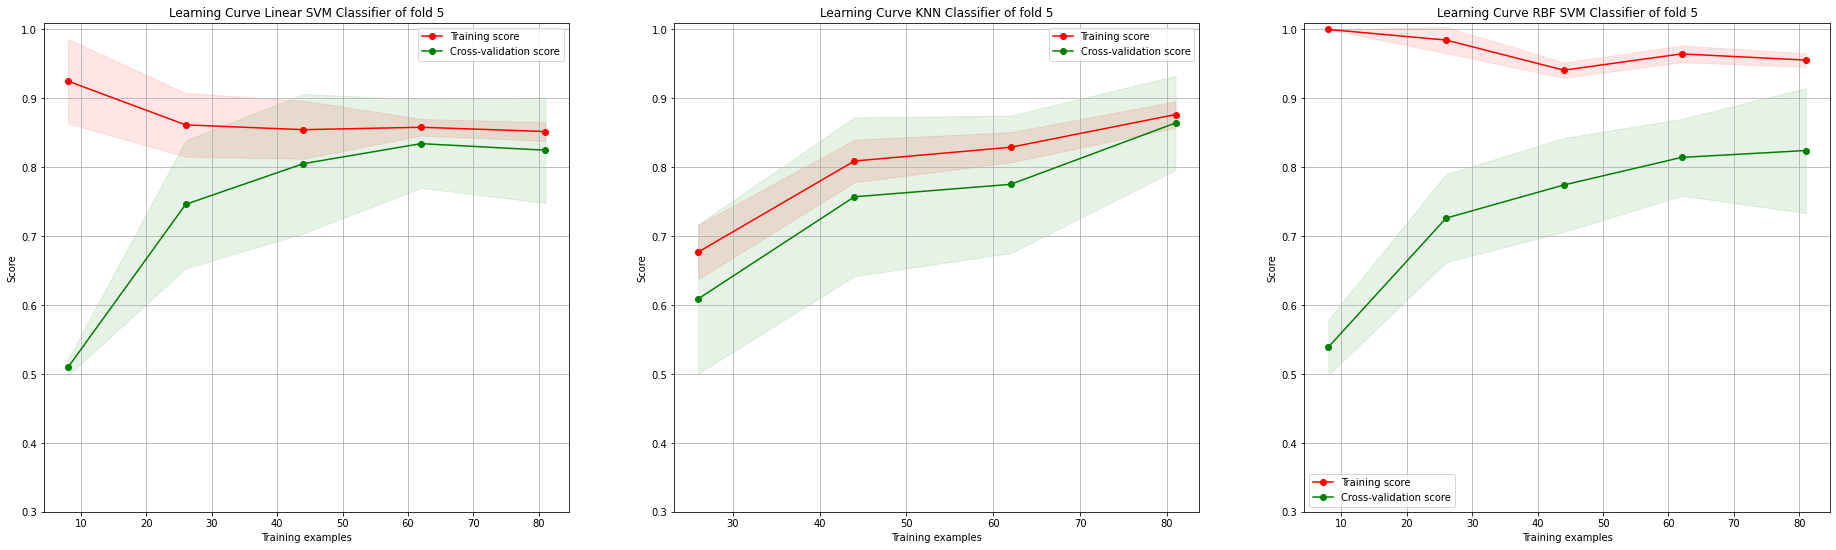

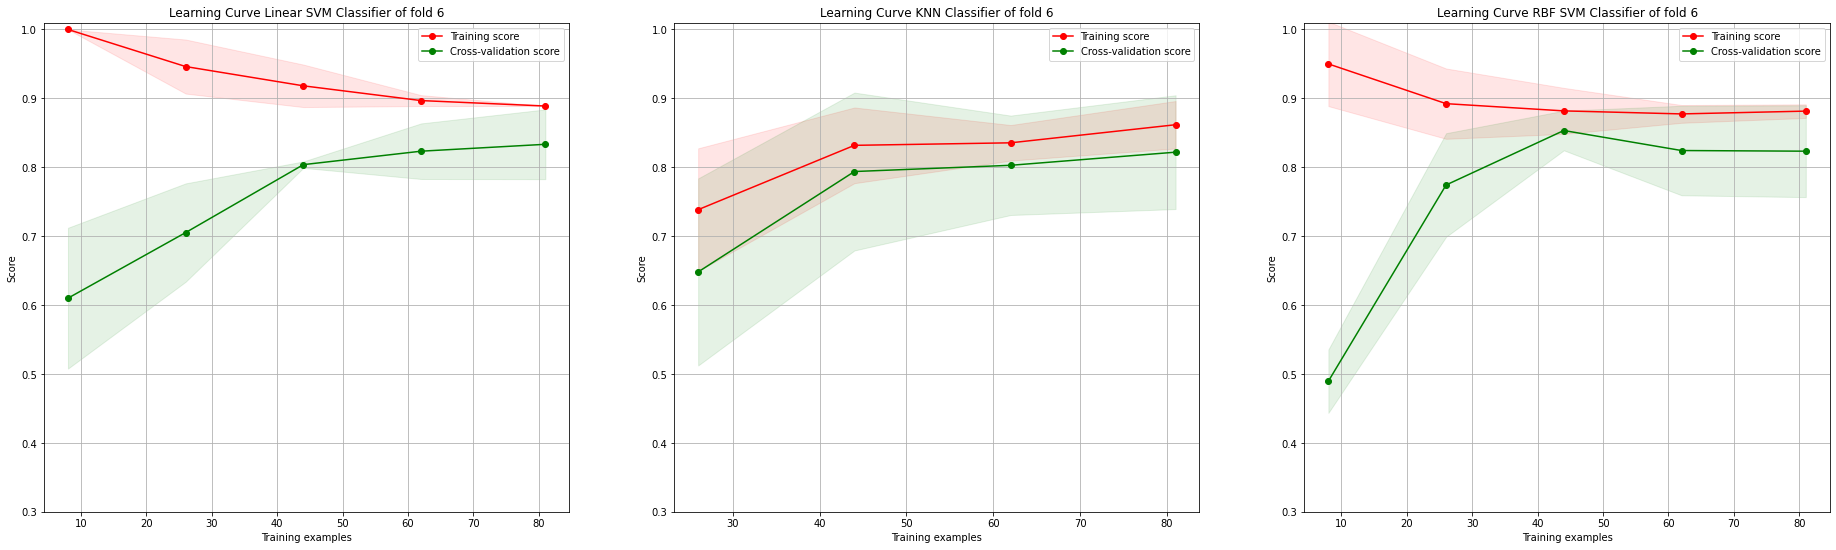

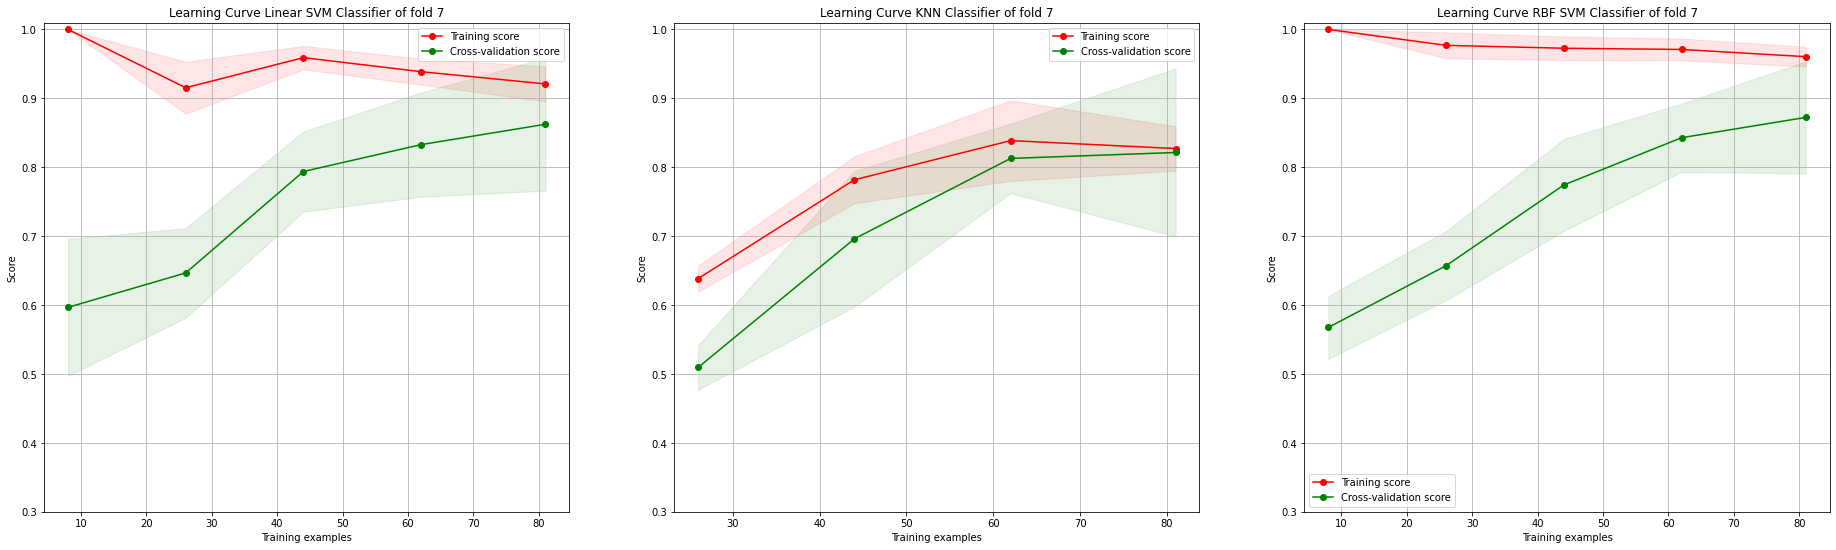

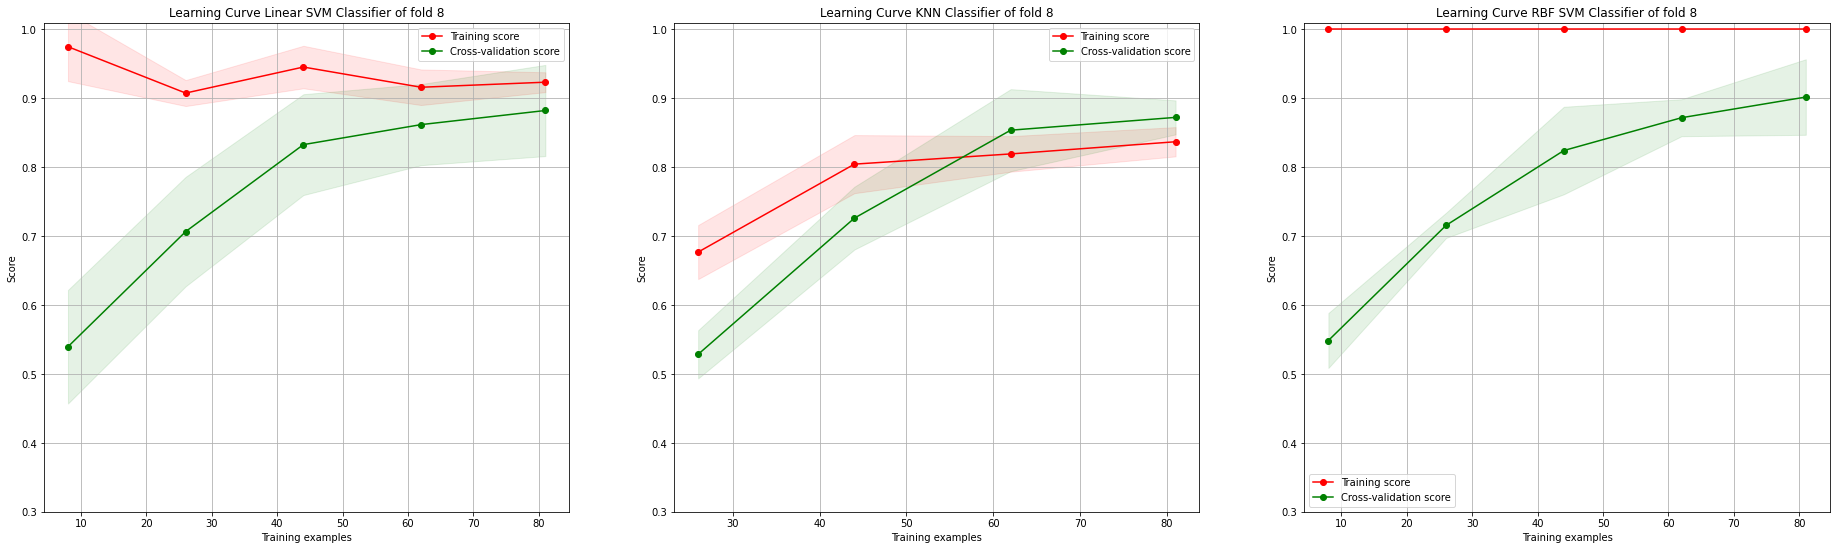

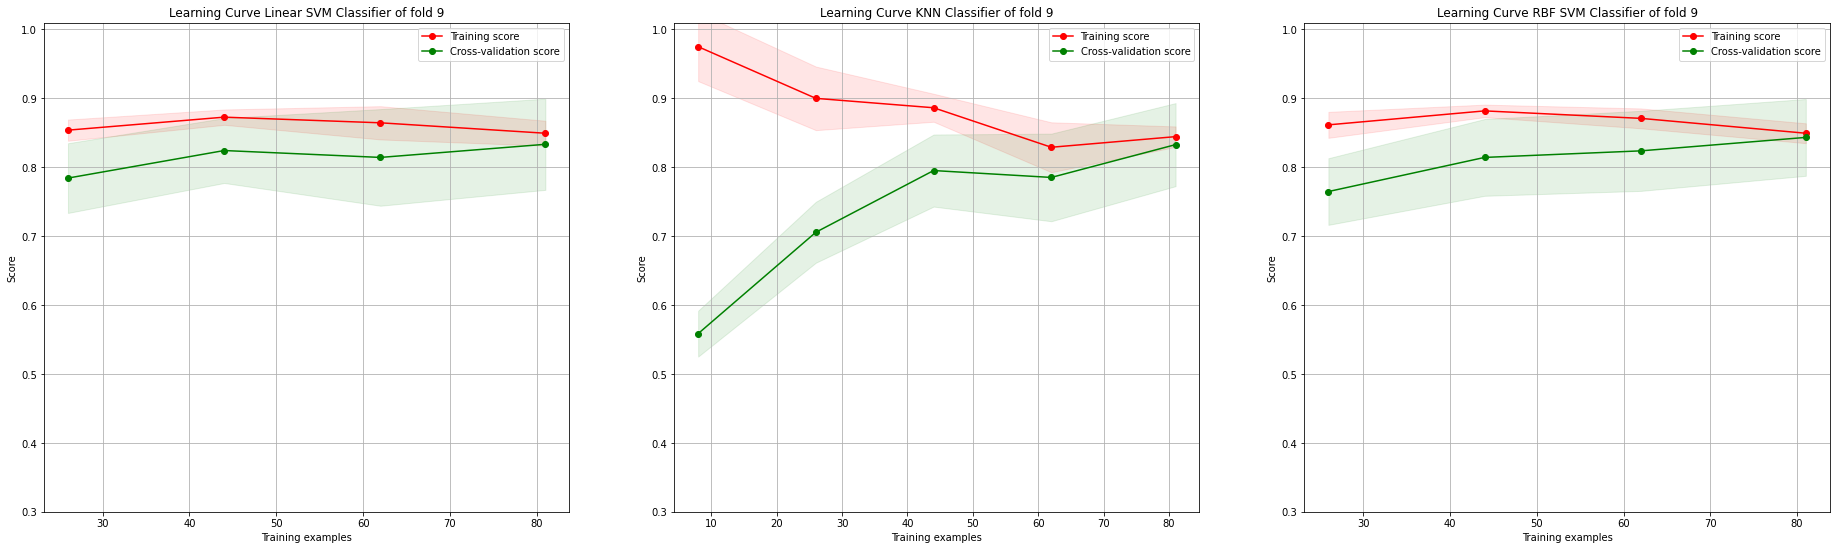

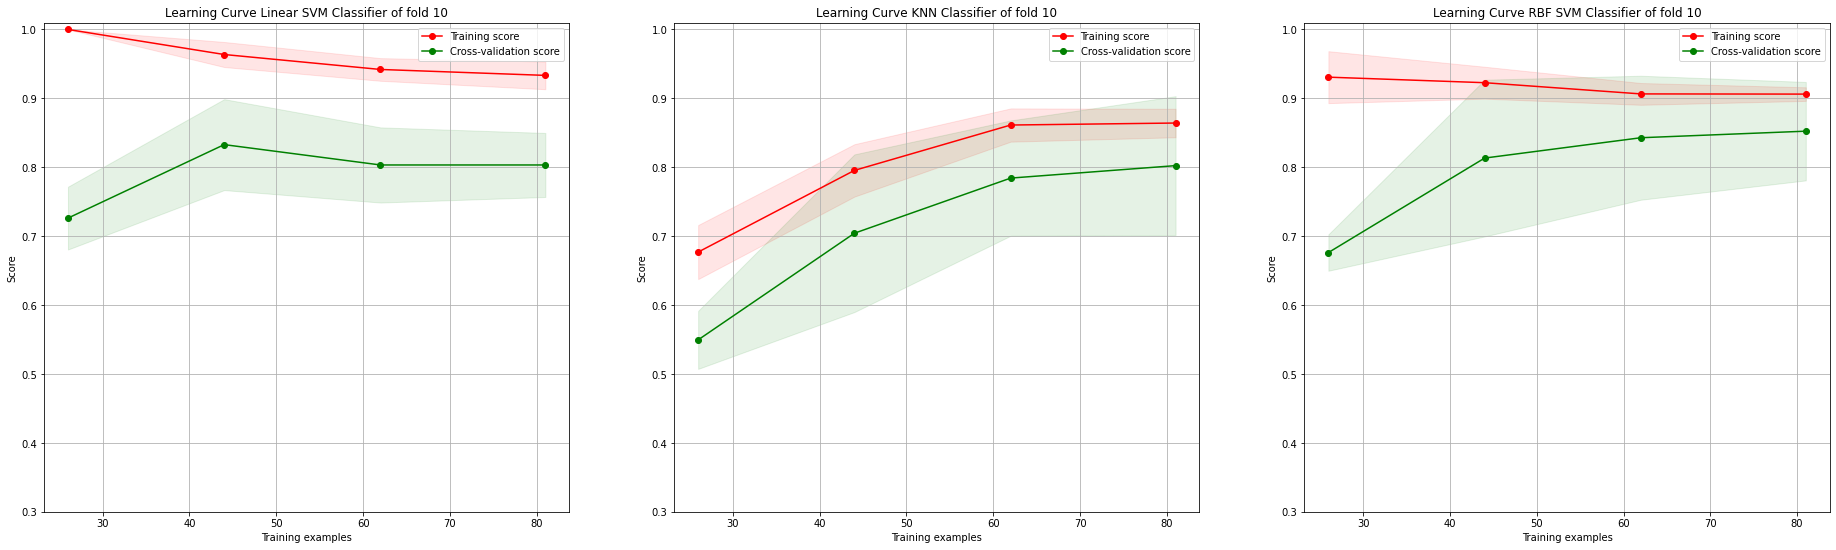

In [ ]:
# =========== configuring outer cross-validation and variables used ============
cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

label = data.pop('label') # Splitting the labels from the dataset

# Variables for linear classifier
fig_lin, ax_lin = plt.subplots(figsize=(12,9))
tprs_lin = []
aucs_lin = []
acc_lin = list()
spec_lin = list()
sens_lin = list()

# Variables for knn classifier
fig_knn, ax_knn = plt.subplots(figsize=(12,9))
tprs_knn = []
aucs_knn = []
acc_knn = list()
spec_knn = list()
sens_knn = list()

# Variables for rbf classifier
fig_rbf, ax_rbf = plt.subplots(figsize=(12,9))
tprs_rbf = []
aucs_rbf = []
acc_rbf = list()
spec_rbf = list()
sens_rbf = list()

mean_fpr = np.linspace(0, 1, 100) # Variable used for plotting mean ROC curve

index = 0 # Used to print the diferent loops in outer cross-validation

# =========== Perform outer cross-validation procedure =========================
for train_ix, test_ix in cv_outer.split(data, label):
  index +=1
  print(f'loop {index}')

  # =========== Preprocessing =========== 
  # split data
  x_train, x_test = data.iloc[train_ix,:], data.iloc[test_ix,:]
  y_train, y_test = label.iloc[train_ix], label.iloc[test_ix]

  # Replacing T12 and T34 for 0 and 1 in trainingsset
  y_train=y_train.replace(to_replace="T34",value="1")
  y_train=y_train.replace(to_replace="T12",value="0")
  
  # Replacing T12 and T34 for 0 and 1 in testset
  y_test=y_test.replace(to_replace="T34",value="1")
  y_test=y_test.replace(to_replace="T12",value="0")
  
  # Fit scaler to trainingsdata
  scaler = MinMaxScaler()
  x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)

  # Apply scaler to test data 
  x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

  # =========== Feature extraction ===========
  # configuring inner cross-validation 
  cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # RFE feature extraction
  model = svm.SVC(kernel='linear', random_state=42)
  rfe = RFECV(model, cv=cv_inner)
  fit = rfe.fit(x_train_scaled, y_train)

  print("Num Features: %s" % (fit.n_features_))
  
  # Select features from data with fitted RFE
  x_train_scaled_selection = x_train_scaled.loc[: , fit.support_]
  x_test_scaled_selection = x_test_scaled.loc[: , fit.support_]

  # =========== Classifier optimalization ===========
  # Linear classifier
  clf = svm.SVC(kernel='linear', probability=True, random_state=42) 

  parameters = {
      'C':            np.arange( 1, 25+1, 1 ).tolist(),
      'gamma':        np.arange( 0.1, 2.5+0.0, 0.1 ).tolist(),          
      }

  model = GridSearchCV(   estimator  = clf,
                          param_grid = parameters,
                          cv = cv_inner                                                                                                     
                                        )         

  model.fit(x_train_scaled_selection, y_train)
  clf_lin = model.best_estimator_
  print(f'Hyperparameters Linear: {model.best_params_}')

  # KNN classifier
  clf = KNeighborsClassifier()

  parameters = {
      'n_neighbors':      np.arange( 1, 30+1, 1 ).tolist(),
      }

  model = GridSearchCV(   estimator  = clf,
                          param_grid = parameters,
                          cv = cv_inner                                                                                                     
                                        )         

  model.fit(x_train_scaled_selection, y_train)
  clf_knn = model.best_estimator_
  print(f'Hyperparameters KNN: {model.best_params_}')

  # RBF classifier
  clf = svm.SVC(kernel='rbf', probability=True, random_state=42)

  parameters = {
      'C':            np.arange( 1, 25+1, 1 ).tolist(),
      'gamma':        np.arange( 0.1, 2.5+0.0, 0.1 ).tolist(),                
      }

  model = GridSearchCV(   estimator  = clf,
                          param_grid = parameters,
                          cv = cv_inner                                                                                                     
                                        )         

  model.fit(x_train_scaled_selection, y_train)
  clf_rbf = model.best_estimator_
  print(f'Hyperparameters RBF: {model.best_params_}')

  # =========== Results ===========
  list_clf = [clf_lin, clf_knn, clf_rbf]
  names = ['Linear SVM Classifier', 'KNN Classifier', 'RBF SVM Classifier']
  
  # === Learning curve ===
  inde = 0 # Index to get correct name out names list
  fig = plt.figure(figsize=(32,3*len(list_clf)))

  for clf in list_clf:
    ax = fig.add_subplot(1, 3, inde + 1)
    title = f"Learning Curve {names[inde]} of fold {index}"
    plot_learning_curve(clf, title, x_train_scaled_selection, y_train, axes=ax, ylim=(0.3, 1.01), cv=cv_inner)

    # Calculate acc, spec and sens
    y_test_val = list(map(int, y_test.tolist()))
    result = clf.predict(x_test_scaled_selection) #fill in best classifier for classifier
    y_pred = list(map(int, result))
    acc = accuracy_score(y_test_val, y_pred)
    sens = recall_score(y_test_val, y_pred)
    spec = precision_score(y_test_val, y_pred)
        
    if inde is 0: # acc, spec and sens for linear classifier
      acc_lin.append(acc)
      spec_lin.append(spec)
      sens_lin.append(sens)
    if inde is 1: # acc, spec and sens for knn classifier
      acc_knn.append(acc)
      spec_knn.append(spec)
      sens_knn.append(sens)
    if inde is 2: # acc, spec and sens for rbf classifier
      acc_rbf.append(acc)
      spec_rbf.append(spec)
      sens_rbf.append(sens)

    inde +=1      

  # === ROC curves plotting ===
  # ROC Linear
  viz = RocCurveDisplay.from_estimator(clf_lin, x_test_scaled_selection, y_test, name=f"ROC fold {index}", alpha=0.3, lw=1, ax=ax_lin)
  interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
  interp_tpr[0] = 0.0
  tprs_lin.append(interp_tpr)
  aucs_lin.append(viz.roc_auc)

  # ROC KNN
  viz = RocCurveDisplay.from_estimator(clf_knn, x_test_scaled_selection, y_test, name=f"ROC fold {index}", alpha=0.3, lw=1, ax=ax_knn)
  interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
  interp_tpr[0] = 0.0
  tprs_knn.append(interp_tpr)
  aucs_knn.append(viz.roc_auc)

  #ROC RBF  
  viz = RocCurveDisplay.from_estimator(clf_rbf, x_test_scaled_selection, y_test, name=f"ROC fold {index}", alpha=0.3, lw=1, ax=ax_rbf)
  interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
  interp_tpr[0] = 0.0
  tprs_rbf.append(interp_tpr)
  aucs_rbf.append(viz.roc_auc)

# === Linear classifier results === 
# Plotting mean ROC curve
ax_lin.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", alpha=0.8)

mean_tpr = np.mean(tprs_lin, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs_lin)
ax_lin.plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)

std_tpr = np.std(tprs_lin, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax_lin.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

ax_lin.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC of linear SVM classifier")
ax_lin.set(ylabel=('True Positive Rate'), xlabel=('False Positive Rate'))
ax_lin.legend(loc="lower right")
fig_lin.show() 

# Printing mean acc, spec, sens and auc
print(f'\nResults for Linear classifier:')
print(f'* mean acc {np.mean(acc_lin):6.4} (std {np.std(acc_lin):6.4})')
print(f'* mean spec {np.mean(spec_lin):6.4} (std {np.std(spec_lin):6.4})')
print(f'* mean sens {np.mean(sens_lin):6.4} (std {np.std(sens_lin):6.4})')
print(f'* mean auc {np.mean(aucs_lin):6.4} (std {np.std(aucs_lin):6.4}) \n')

# === KNN classifier results === 
# Plotting mean ROC curve
ax_knn.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", alpha=0.8)

mean_tpr = np.mean(tprs_knn, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs_knn)
ax_knn.plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)

std_tpr = np.std(tprs_knn, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax_knn.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

ax_knn.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC of KNN classifier")
ax_knn.set(ylabel=('True Positive Rate'), xlabel=('False Positive Rate'))
ax_knn.legend(loc="lower right")
fig_knn.show() 

# Printing mean acc, spec, sens and auc
print(f'Results for KNN classifier:')
print(f'* mean acc {np.mean(acc_knn):6.4} (std {np.std(acc_knn):6.4})')
print(f'* mean spec {np.mean(spec_knn):6.4} (std {np.std(spec_knn):6.4})')
print(f'* mean sens {np.mean(sens_knn):6.4} (std {np.std(sens_knn):6.4})')
print(f'* mean auc {np.mean(aucs_knn):6.4} (std {np.std(aucs_knn):6.4}) \n')

# === RBF classifier results === 
# Plotting mean ROC curve
ax_rbf.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", alpha=0.8)

mean_tpr = np.mean(tprs_rbf, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs_rbf)
ax_rbf.plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)

std_tpr = np.std(tprs_rbf, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax_rbf.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

ax_rbf.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC of RBF SVM classifier")
ax_rbf.set(ylabel=('True Positive Rate'), xlabel=('False Positive Rate'))
ax_rbf.legend(loc="lower right")
fig_rbf.show() 

# Printing mean acc, spec, sens and auc
print(f'Results for RBF classifier:')
print(f'* mean acc {np.mean(acc_rbf):6.4} (std {np.std(acc_rbf):6.4})')
print(f'* mean spec {np.mean(spec_rbf):6.4} (std {np.std(spec_rbf):6.4})')
print(f'* mean sens {np.mean(sens_rbf):6.4} (std {np.std(sens_rbf):6.4})')
print(f'* mean auc {np.mean(aucs_rbf):6.4} (std {np.std(aucs_rbf):6.4}) \n')

# ==============================================================================